# Modelización 

**Resumen** Entrada de variables en el modelo: 

Leyenda:
* **Candidata**: variable a incluir en los modelos.
* **Descartada**: variable que NO vamos a incluir en los modelos.


**Entrada de variables en el modelo:**

* Age - **Candidata**           Correlación 0.34
* Tenure - **Descartada**       Correlación -0.01
* NumOfProducts - **Candidata**       Correlación -0.20
* IsActiveMember - **Candidata**       Correlación -0.21
* Sex - **Candidata**       Correlación -0.14
* CreditScore - **Descartada**      Correlación -0.03
* Balance - **Candidata**       Correlación 0.13
* Countries - **Candidata** Por lo explicado en Tabla7 y Grafico1
* EstimatedSalary - **Descartada**      Correlación 0.02
* HasCrCard - **Descartada**        Correlación -0.02

* Tenure_Age - **Descartada**       Correlación -0.13
* Age_Tenure_product - **Descartada**       Correlación 0.11
* Mem__no__Products - **Candidata**       Correlación -0.23
* Cred_Bal_Sal - **Candidata**       Correlación 0.10
* Bal_sal - **Candidata**       Correlación 0.11

Modelos a probar:

* Regresión logística

* *Random Forest*

* Bayes: Bernouilli y Gauss

* Árbol de decisión

* K-vecinos cercanos

* Boosting

 

Carga de librerías y de datos - no incluir proyecto final

In [1]:
#generales

import requests
import pandas as pd
from io import StringIO
import time 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

#preprocesamiento y optimización
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, chi2

#modelización
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge

#métricas
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score, precision_score, recall_score

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
url="/workspaces/Isa-Project/data/data_clean.csv"
data_clean=pd.read_csv(url)

#observamos que se hayan cargado correctamente los datos con las primeras 5 filas del dataset
data_clean.head()

,Unnamed: 0,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Mem__no__Products,Age_Tenure_product,Sex,Countries,Tenure_Age_calc,Cred_Bal_Sal_out,Bal_sal_out
0,0,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,0.0,99.0,1,1,0.090909,0.000000,0.000000
1,1,627.0,33.0,1.0,0.00,2.0,1,1,49503.50,0,2.0,33.0,1,1,0.030303,0.000000,0.000000
2,2,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,0.0,400.0,1,1,0.250000,0.000000,0.000000
3,3,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1.0,68.0,1,1,0.058824,1022.940581,1.760655
4,4,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,2.0,165.0,1,3,0.151515,0.000000,0.000000


Vamos a crear un data set con las variables a incluir iniciales: Age, NumOfProducts, IsActiveMember, Sex, Balance, Countries, Mem__no__Products, Cred_Bal_Sal, Bal_sal

In [4]:
vars_mod1=["Age", "NumOfProducts", "IsActiveMember", "Sex", "Balance", "Countries"]
vars_mod_aux= ["Mem__no__Products","Cred_Bal_Sal_out", "Bal_sal_out"]
tot_cols=vars_mod1+vars_mod_aux

Obtención de los datos con las columnas seleccionadas

In [98]:
y=data_clean["Exited"]
X=data_clean[tot_cols]

Para balancer los datos

In [8]:
# Muestra del x% de la clase 0 y del 1-x% de la clase 1

total=len(data_clean['Exited'])
tot_1=len(data_clean[data_clean['Exited'] == 1])
frac_0=0.75
tot_0=int(round(tot_1/(1-frac_0)-tot_1,0))

sample_class_0 = data_clean[data_clean['Exited'] == 0].sample(n=tot_0, random_state=42)
sample_class_1 = data_clean[data_clean['Exited'] == 1]

# Combinamos las muestras para obtener el conjunto de datos balanceado
balanced_data = pd.concat([sample_class_0, sample_class_1])

# Verifica el balance resultante
print(balanced_data['Exited'].value_counts())
print(f"Perdida de datos: {len(data_clean['Exited'])-len(balanced_data['Exited'])}  -- {round((1-len(balanced_data['Exited'])/len(data_clean['Exited']))*100,2)}% ")

Exited
0    110859
1     36953
Name: count, dtype: int64
Perdida de datos: 27173  -- 15.53% 


In [9]:
#Si vamos a coger la muestra balanceada:

y=balanced_data["Exited"]
X=balanced_data[tot_cols]

Separamos las muestras de entrenamiento y test

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

Normalizamos los datos

In [11]:
 
scaler = StandardScaler()
scaler.fit(X_train)

cols=X.columns
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = cols)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = cols)



**REGRESION LOGÍSTICA**

In [16]:
#Regresión
model = LogisticRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

#Lasso
lasso_model = Lasso(alpha = 0.1, max_iter = 300)
lasso_model.fit(X_train_norm, y_train)
y_pred_lasso = lasso_model.predict(X_test_norm)

#Ridge
ridge_model = Ridge(alpha = 0.1, max_iter = 300)
ridge_model.fit(X_train_norm, y_train)
y_pred_ridge = ridge_model.predict(X_test_norm)

Métricas:

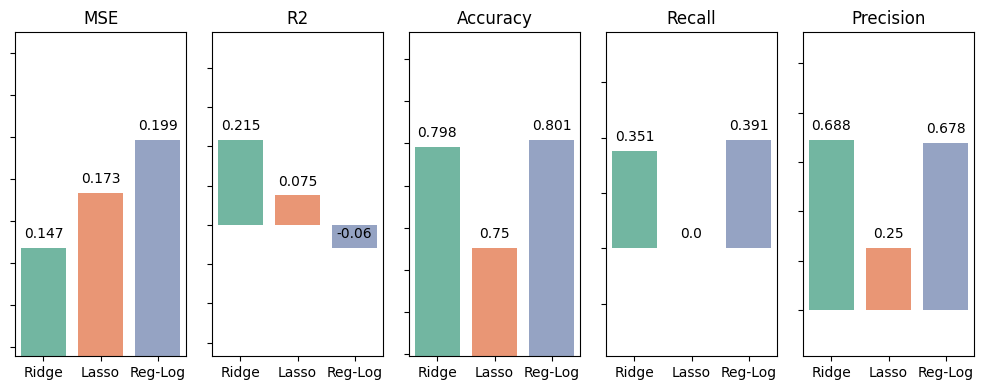

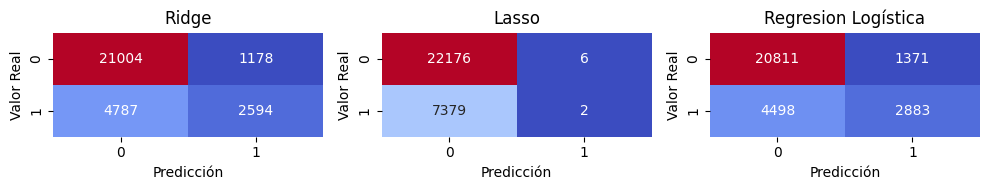

In [17]:
y_pred_ridge_round=y_pred_ridge.round(0)
y_pred_lasso_round=y_pred_lasso.round(0)

# Calcular el error cuadrático medio
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
MSE= mean_squared_error(y_test, y_pred)

#Calcular el R2
ridge_r2=r2_score(y_test, y_pred_ridge)
lasso_r2=r2_score(y_test, y_pred_lasso)
R2=r2_score(y_test, y_pred)

#Calcular el accuracy
ridge_acc=accuracy_score(y_test, y_pred_ridge_round)
lasso_acc=accuracy_score(y_test, y_pred_lasso_round)
model_acc=accuracy_score(y_test, y_pred)

#Calcular la matriz de confusión
ridge_conf=cm = confusion_matrix(y_test, y_pred_ridge_round)
lasso_conf=confusion_matrix(y_test, y_pred_lasso_round)
model_conf=confusion_matrix(y_test, y_pred)

#Calcular el recall
ridge_rec=recall_score(y_test, y_pred_ridge_round)
lasso_rec=recall_score(y_test, y_pred_lasso_round)
model_rec=recall_score(y_test, y_pred)

#Calcular la precisión
ridge_prec=precision_score(y_test, y_pred_ridge_round)
lasso_prec=precision_score(y_test, y_pred_lasso_round)
model_prec=precision_score(y_test, y_pred)


valoresMSE=[ridge_mse,lasso_mse,MSE]
valoresR2=[ridge_r2,lasso_r2,R2]
valoresAcc=[ridge_acc,lasso_acc,model_acc]
valoresRec=[ridge_rec,lasso_rec,model_rec]
valoresPrec=[ridge_prec,lasso_prec,model_prec]

nombs=['Ridge','Lasso','Reg-Log']


fig, axis= plt.subplots(1,5,figsize=(10,4))

#FILA 1
## 1º GRÁFICO - ERROR CUADRÁTICO MEDIO

ax1=sns.barplot(x=nombs,y=valoresMSE,hue=nombs,ax=axis[0],palette="Set2")
lim0=min(valoresMSE)-(max(valoresMSE)-min(valoresMSE))
lim1=max(valoresMSE)+(max(valoresMSE)-min(valoresMSE))
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
axis[0].set_yticklabels([])
axis[0].set_ylim(lim0,lim1)
axis[0].set_title("MSE")

## 2º GRÁFICO - R2
ax2=sns.barplot(x=nombs,y=valoresR2,hue=nombs,ax=axis[1],palette="Set2")
lim0=min(valoresR2)-(max(valoresR2)-min(valoresR2))
lim1=max(valoresR2)+(max(valoresR2)-min(valoresR2))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[1].set_yticklabels([])
axis[1].set_ylim(lim0,lim1)
axis[1].set_title("R2")

## 3º GRÁFICO - ACCURACY
ax2=sns.barplot(x=nombs,y=valoresAcc,hue=nombs,ax=axis[2],palette="Set2")
lim0=min(valoresAcc)-(max(valoresAcc)-min(valoresAcc))
lim1=max(valoresAcc)+(max(valoresAcc)-min(valoresAcc))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[2].set_yticklabels([])
axis[2].set_ylim(lim0,lim1)
axis[2].set_title("Accuracy")

## 4º GRÁFICO - RECALL
ax2=sns.barplot(x=nombs,y=valoresRec,hue=nombs,ax=axis[3],palette="Set2")
lim0=min(valoresRec)-(max(valoresRec)-min(valoresRec))
lim1=max(valoresRec)+(max(valoresRec)-min(valoresRec))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[3].set_yticklabels([])
axis[3].set_ylim(lim0,lim1)
axis[3].set_title("Recall")

## 5º GRÁFICO - PRECISIÓN
ax2=sns.barplot(x=nombs,y=valoresPrec,hue=nombs,ax=axis[4],palette="Set2")
lim0=min(valoresPrec)-(max(valoresPrec)-min(valoresPrec))
lim1=max(valoresPrec)+(max(valoresPrec)-min(valoresPrec))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[4].set_yticklabels([])
axis[4].set_ylim(lim0,lim1)
axis[4].set_title("Precision")

plt.tight_layout()
plt.show()

#FILA 2

fig, axis= plt.subplots(1,3,figsize=(10,2))
## 1º GRÁFICO

sns.heatmap(ridge_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[0].set_xlabel('Predicción')
axis[0].set_ylabel('Valor Real')
axis[0].set_title('Ridge')

sns.heatmap(lasso_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1].set_xlabel('Predicción')
axis[1].set_ylabel('Valor Real')
axis[1].set_title('Lasso')

sns.heatmap(model_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[2],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[2].set_xlabel('Predicción')
axis[2].set_ylabel('Valor Real')
axis[2].set_title('Regresion Logística')

plt.tight_layout()
plt.show()



Vemos que el mejor modelo habiendo metido la regularización es el **modelo de regresión logística** con un **accuracy de 82,55%**

Ahora vamos a comparar el resto de modelos, y, una vez elegido un modelo, podemos optimizarlo con los hiperparámetros.

**RANDOM FOREST**

In [18]:
model_RF = RandomForestClassifier(random_state = 42)
model_RF.fit(X_train_norm, y_train)
y_pred_RF = model_RF.predict(X_test_norm)
#x=model.get_params()

#print("Parámetros del árbol de decisión:")
#for param, value in x.items():
#    print(f"{param}: {value}")

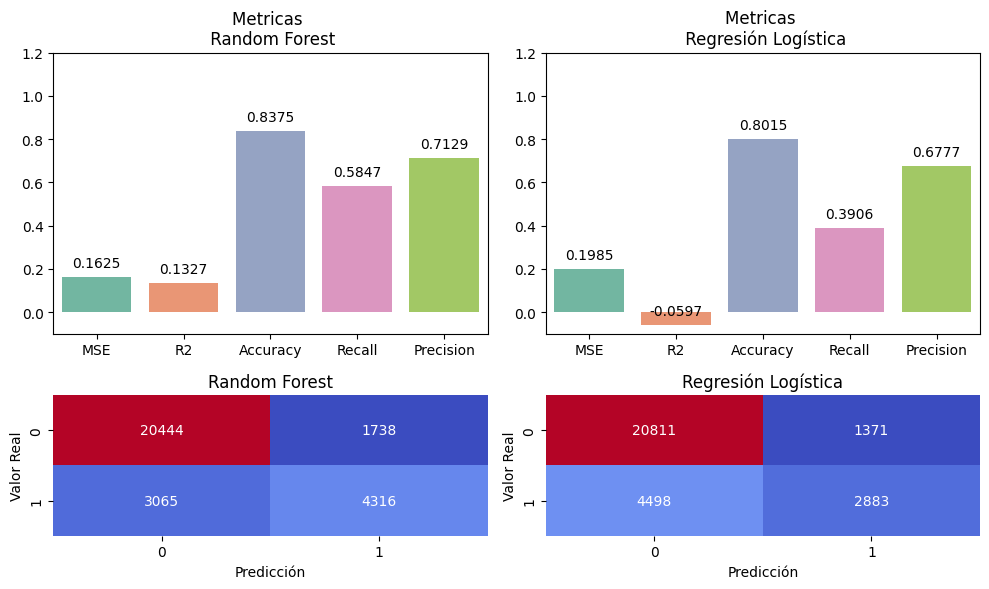

In [19]:

MSE_RF= mean_squared_error(y_test, y_pred_RF)
R2_RF=r2_score(y_test, y_pred_RF)
model_acc_RF=accuracy_score(y_test, y_pred_RF)
rec_RF=recall_score(y_test, y_pred_RF)
prec_RF=precision_score(y_test, y_pred_RF)

RF_conf=confusion_matrix(y_test, y_pred_RF)

valores_model=[MSE,R2,model_acc,model_rec,model_prec]
valores_RF=[MSE_RF,R2_RF,model_acc_RF,rec_RF,prec_RF]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('Random Forest')

ax1=sns.barplot(x=nombs,y=valores_model,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Regresión Logística")

sns.heatmap(model_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Regresión Logística')

plt.tight_layout()
plt.show()



**NAIVE BAYES**

In [82]:
model_Gauss=GaussianNB()
model_Gauss.fit(X_train_norm,y_train)
y_pred_Gauss=model_Gauss.predict(X_test_norm)

model_Bern=BernoulliNB()
model_Bern.fit(X_train_norm,y_train)
y_pred_Bern=model_Bern.predict(X_test_norm)

/tmp/ipykernel_543/594799459.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_543/594799459.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_543/594799459.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_543/594799459.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[3].set_xticklabels(axis[3].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_543/594799459.py:

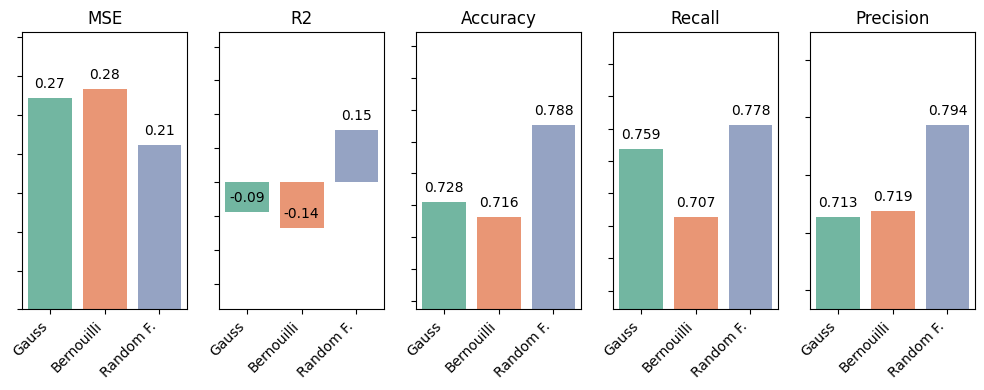

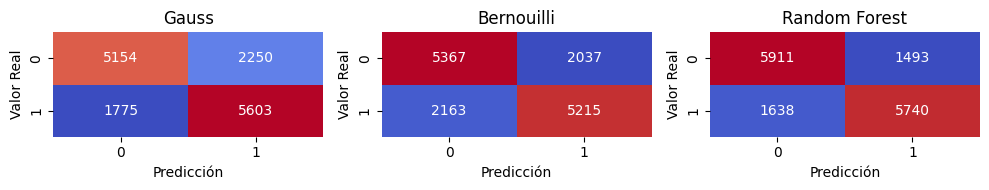

In [87]:
# Calcular el error cuadrático medio

Gauss_mse = mean_squared_error(y_test, y_pred_Gauss)
Bern_mse= mean_squared_error(y_test, y_pred_Bern)

Gauss_r2=r2_score(y_test, y_pred_Gauss)
Bern_r2=r2_score(y_test, y_pred_Bern)

Gauss_acc=accuracy_score(y_test, y_pred_Gauss)
Bern_acc=accuracy_score(y_test, y_pred_Bern)

Gauss_rec=recall_score(y_test, y_pred_Gauss)
Bern_rec=recall_score(y_test, y_pred_Bern)

Gauss_prec=precision_score(y_test, y_pred_Gauss)
Bern_prec=precision_score(y_test, y_pred_Bern)

Gauss_conf= confusion_matrix(y_test, y_pred_Gauss)
Bern_conf= confusion_matrix(y_test, y_pred_Bern)

valoresMSE_=[Gauss_mse,Bern_mse,MSE_RF]
valoresR2_=[Gauss_r2,Bern_r2,R2_RF]
valoresAcc_=[Gauss_acc,Bern_acc,model_acc_RF]
valoresRec_=[Gauss_rec,Bern_rec,rec_RF]
valoresPrec_=[Gauss_prec,Bern_prec,prec_RF]

nombs=['Gauss','Bernouilli','Random F.']


fig, axis= plt.subplots(1,5,figsize=(10,4))

#FILA 1
## 1º GRÁFICO

ax1=sns.barplot(x=nombs,y=valoresMSE_,hue=nombs,ax=axis[0],palette="Set2")
lim0=0
lim1=max(valoresMSE_)+(max(valoresMSE_)-min(valoresMSE_))
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45, ha='right')
axis[0].set_yticklabels([])
axis[0].set_ylim(lim0,lim1)
axis[0].set_title("MSE")

## 2º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresR2_,hue=nombs,ax=axis[1],palette="Set2")
lim0=min(valoresR2_)-(max(valoresR2_)-min(valoresR2_))+0.05
lim1=max(valoresR2_)+(max(valoresR2_)-min(valoresR2_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),2)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=45, ha='right')
axis[1].set_yticklabels([])
axis[1].set_ylim(lim0,lim1)
axis[1].set_title("R2")

## 3º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresAcc_,hue=nombs,ax=axis[2],palette="Set2")
lim0=min(valoresAcc_)-(max(valoresAcc_)-min(valoresAcc_))
lim1=max(valoresAcc_)+(max(valoresAcc_)-min(valoresAcc_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45, ha='right')
axis[2].set_yticklabels([])
axis[2].set_ylim(lim0,lim1)
axis[2].set_title("Accuracy")

## 4º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresRec_,hue=nombs,ax=axis[3],palette="Set2")
lim0=min(valoresRec_)-(max(valoresRec_)-min(valoresRec_))
lim1=max(valoresRec_)+(max(valoresRec_)-min(valoresRec_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[3].set_xticklabels(axis[3].get_xticklabels(), rotation=45, ha='right')
axis[3].set_yticklabels([])
axis[3].set_ylim(lim0,lim1)
axis[3].set_title("Recall")

## 4º GRÁFICO
ax2=sns.barplot(x=nombs,y=valoresPrec_,hue=nombs,ax=axis[4],palette="Set2",)
lim0=min(valoresPrec_)-(max(valoresPrec_)-min(valoresPrec_))
lim1=max(valoresPrec_)+(max(valoresPrec_)-min(valoresPrec_))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),3)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[4].set_xticklabels(axis[4].get_xticklabels(), rotation=45, ha='right')
axis[4].set_yticklabels([])
axis[4].set_ylim(lim0,lim1)
axis[4].set_title("Precision")


plt.tight_layout()
plt.show()

#FILA 2
fig, axis= plt.subplots(1,3,figsize=(10,2))
## 1º GRÁFICO

sns.heatmap(Gauss_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[0].set_xlabel('Predicción')
axis[0].set_ylabel('Valor Real')
axis[0].set_title('Gauss')

sns.heatmap(Bern_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1].set_xlabel('Predicción')
axis[1].set_ylabel('Valor Real')
axis[1].set_title('Bernouilli')

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[2],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[2].set_xlabel('Predicción')
axis[2].set_ylabel('Valor Real')
axis[2].set_title('Random Forest')

plt.tight_layout()
plt.show()



**DECISION TREE**

In [88]:
model_DT = DecisionTreeClassifier(random_state = 42)
model_DT.fit(X_train_norm, y_train)
y_pred_DT=model_DT.predict(X_test_norm)

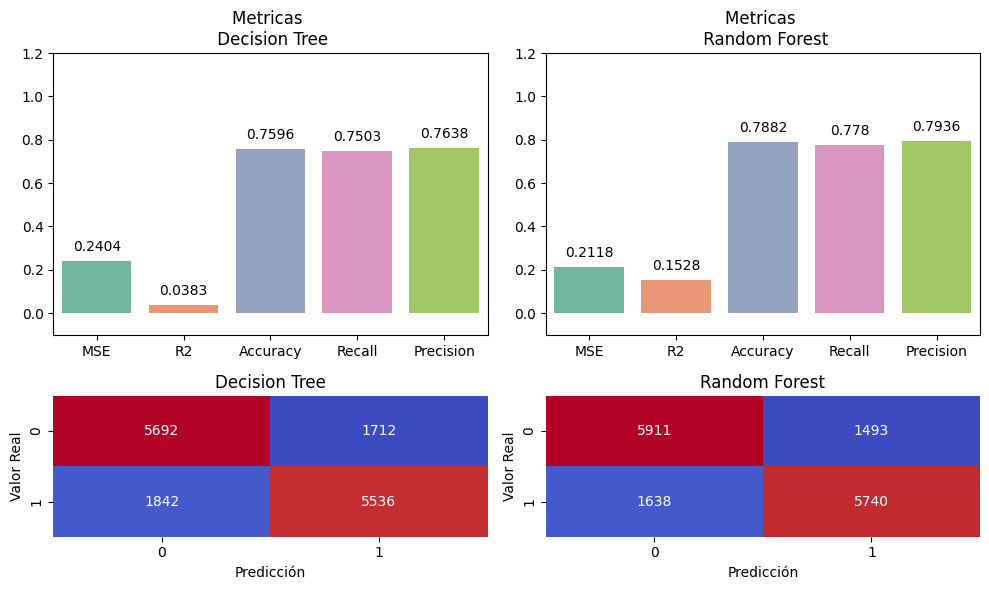

In [89]:

MSE_DT= mean_squared_error(y_test, y_pred_DT)
R2_DT=r2_score(y_test, y_pred_DT)
model_acc_DT=accuracy_score(y_test, y_pred_DT)
rec_DT=recall_score(y_test, y_pred_DT)
prec_DT=precision_score(y_test, y_pred_DT)

DT_conf=confusion_matrix(y_test, y_pred_DT)

valores_DT=[MSE_DT,R2_DT,model_acc_DT,rec_DT,prec_DT]
valores_RF=[MSE_RF,R2_RF,model_acc_RF,rec_RF,prec_RF]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_DT,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n Decision Tree")

sns.heatmap(DT_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('Decision Tree')

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Random Forest')

plt.tight_layout()
plt.show()


**K-NEIGHBORS**

In [90]:
model_KN = KNeighborsClassifier()
model_KN.fit(X_train_norm, y_train)
y_pred_KN=model_KN.predict(X_test_norm)

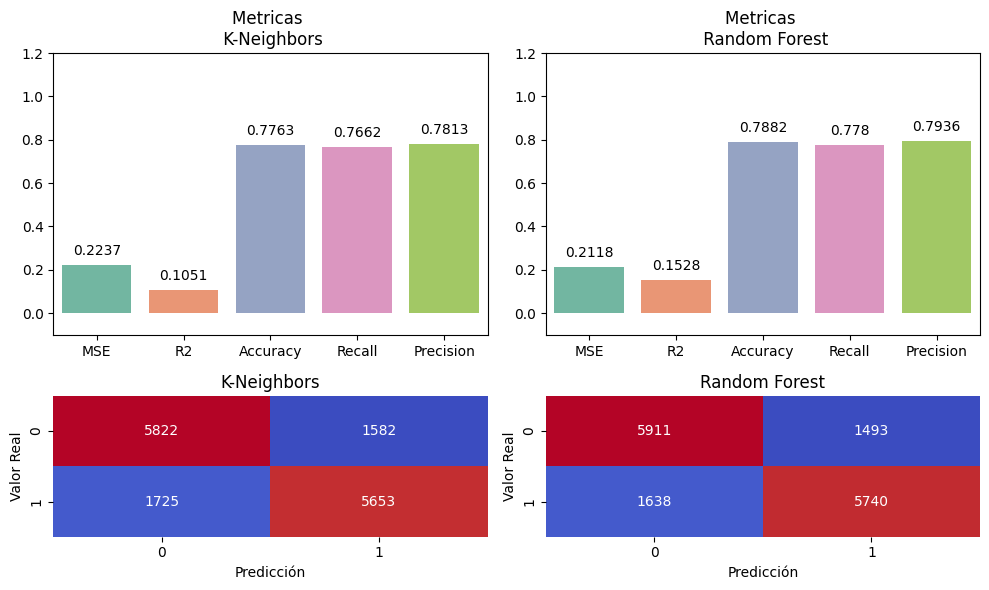

In [91]:

MSE_KN= mean_squared_error(y_test, y_pred_KN)
R2_KN=r2_score(y_test, y_pred_KN)
model_acc_KN=accuracy_score(y_test, y_pred_KN)
rec_KN=recall_score(y_test, y_pred_KN)
prec_KN=precision_score(y_test, y_pred_KN)

KN_conf=confusion_matrix(y_test, y_pred_KN)

valores_KN=[MSE_KN,R2_KN,model_acc_KN,rec_KN,prec_KN]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_KN,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n K-Neighbors")

sns.heatmap(KN_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('K-Neighbors')

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Random Forest')

plt.tight_layout()
plt.show()

**BOOSTING**

In [20]:
model_Boo = XGBClassifier()
model_Boo.fit(X_train_norm, y_train)
y_pred_Boo=model_Boo.predict(X_test_norm)


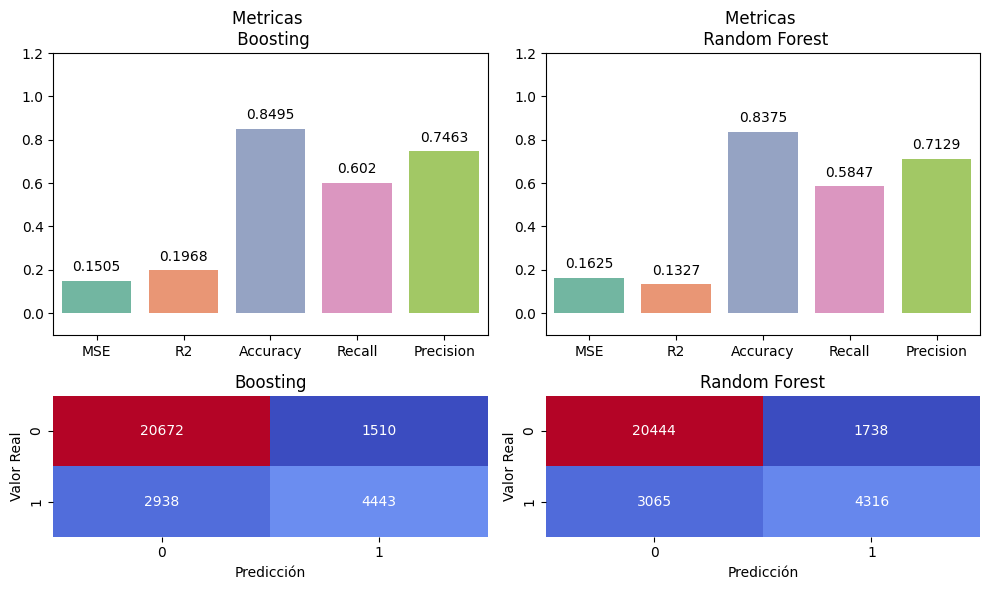

In [21]:

MSE_Boo= mean_squared_error(y_test, y_pred_Boo)
R2_Boo=r2_score(y_test, y_pred_Boo)
model_acc_Boo=accuracy_score(y_test, y_pred_Boo)
rec_Boo=recall_score(y_test, y_pred_Boo)
prec_Boo=precision_score(y_test, y_pred_Boo)

KN_conf=confusion_matrix(y_test, y_pred_Boo)

valores_Boo=[MSE_Boo,R2_Boo,model_acc_Boo,rec_Boo,prec_Boo]

nombs=['MSE','R2','Accuracy','Recall','Precision']

fig, axis= plt.subplots(2,2,figsize=(10,6), gridspec_kw={'height_ratios': [2, 1]})

ax1=sns.barplot(x=nombs,y=valores_Boo,hue=nombs,ax=axis[0,0],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,0].set_ylim(lim0,lim1)
axis[0,0].set_title("Metricas \n Boosting")

sns.heatmap(KN_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,0],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,0].set_xlabel('Predicción')
axis[1,0].set_ylabel('Valor Real')
axis[1,0].set_title('Boosting')

ax1=sns.barplot(x=nombs,y=valores_RF,hue=nombs,ax=axis[0,1],palette="Set2")
lim0=-0.1
lim1=1.2
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0,1].set_ylim(lim0,lim1)
axis[0,1].set_title("Metricas \n Random Forest")

sns.heatmap(RF_conf, annot=True, fmt='g', cmap='coolwarm', cbar=False, ax=axis[1,1],
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

axis[1,1].set_xlabel('Predicción')
axis[1,1].set_ylabel('Valor Real')
axis[1,1].set_title('Random Forest')

plt.tight_layout()
plt.show()

Comparativa de Balanceos:

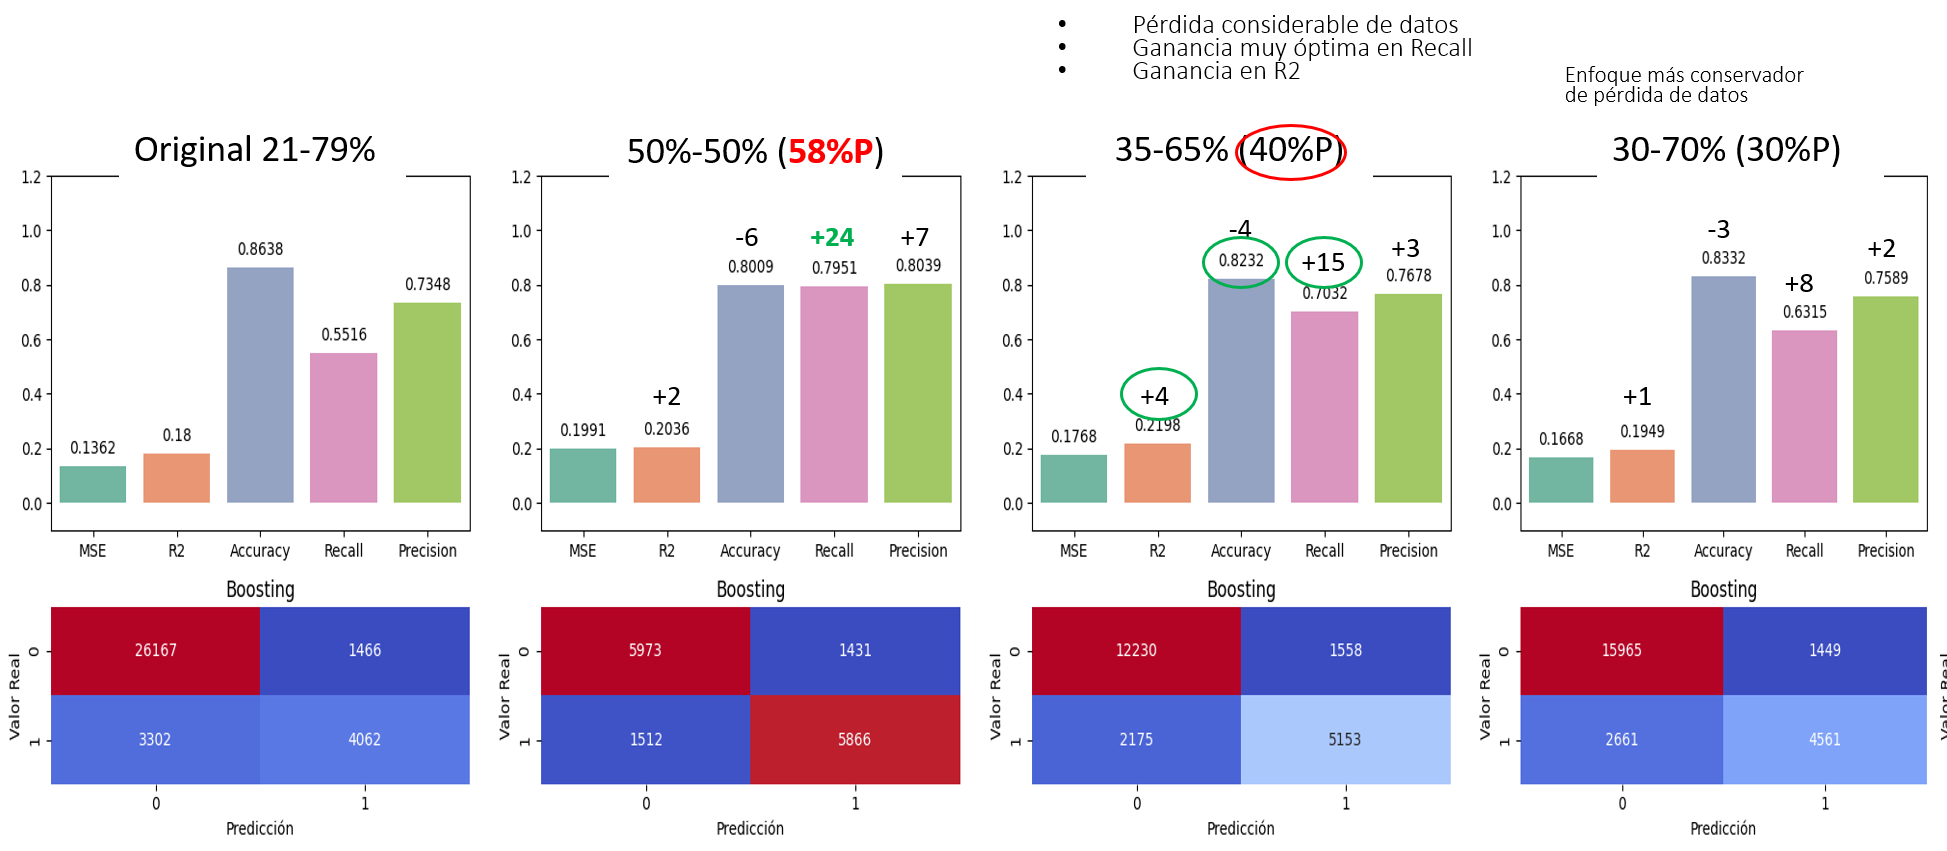

In [22]:
from IPython.display import display
from PIL import Image
import io

#ruta_imagen = 'nombre_de_la_imagen.jpg'  # Reemplaza 'nombre_de_la_imagen.jpg' con la ruta de tu imagen

# Abre la imagen y la muestra en el notebook
imagen = Image.open("/workspaces/Isa-Project/data/Comparativa balanceos.png")
display(imagen)